---
title: "SWD Occurence Rate"
format:
  html:
    code-fold: true
output-file: or.html

---

In [27]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

#### Import libraries

In [28]:
from fastcore.utils import *
from fastcore.test import *

from ids_finder.utils.basic import *

from datetime import timedelta

import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np

import seaborn as sns

In [29]:
import warnings

# This will filter out all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Connect `python` with `R` kernel

In [30]:
%load_ext rpy2.ipython
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### `Kedro`

In [31]:
#| output: False
from ids_finder.utils.basic import load_catalog

catalog = load_catalog('../../')
catalog.list()

[10/27/23 12:23:31] WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ke ]8;id=552615;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=692765;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             dro/io/partitioned_dataset.py:200: KedroDeprecationWarning:                           
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   


[
    'sta.raw_state_merged',
    'jno.raw_mag_1s',
    'jno.raw_state',
    'model.raw_jno_ss_se_1min',
    'model.preprocessed_jno_ss_se_1min',
    'JNO_index',
    'thb.raw_state_sw',
    'parameters',
    'params:tau',
    'params:jno_start_date',
    'params:jno_end_date',
    'params:jno_1s_params',
    'params:jno_1s_params.bcols',
    'params:jno_1s_params.data_resolution',
    'params:jno.extract_params',
    'params:jno.extract_params.bcols',
    'params:jno.extract_params.data_resolution',
    'params:sta.extract_params',
    'params:sta.extract_params.bcols',
    'params:sta.extract_params.data_resolution',
    'params:thb',
    'params:thb.mag',
    'params:thb.mag.bcols',
    'params:thb.mag.time_resolution',
    'params:thb.mag.coords',
    'params:jno.mag',
    'params:jno.mag.coords',
    'params:sta.mag',
    'params:sta.mag.coords',
    'params:thb.extract_params',
    'params:thb.extract_params.bcols',
    'params:thb.extract_params.data_resolution',
    'params:om

#### Plotting style

In [32]:
import matplotlib.pyplot as plt
import scienceplots
from ids_finder.utils.plot import savefig

plt.style.use(['science', 'nature', 'notebook'])


### Loading all datasets from different sources

In [33]:
from ids_finder.datasets import cIDsDataset

In [34]:
sta_candidate = cIDsDataset(sat_id="STA", tau=60, ts=1, catalog=catalog)
jno_candidate = cIDsDataset(sat_id="JNO", tau=60, ts=1, catalog=catalog)
thb_candidate = cIDsDataset(sat_id="THB", tau=60, ts=1, catalog=catalog)

                    INFO     Loading data from 'candidates.STA_ts_1s_tau_60s'                   ]8;id=243670;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=832684;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'STA.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=898943;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365308;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.JNO_ts_1s_tau_60s'                   ]8;id=315380;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=664286;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'JNO.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=62647;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941103;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.THB_ts_1s_tau_60s'                   ]8;id=722307;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=391044;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'THB.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=365400;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=486822;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

ARTEMIS missions needs additional care as they are not always in the solar wind.

In [35]:
from ids_finder.utils.basic import filter_tranges_df

In [36]:
thb_inter_state_sw: pl.LazyFrame = catalog.load('thb.inter_state_sw')
start, end = thb_inter_state_sw.select(['start', 'end']).collect()

thb_sw_candidate = cIDsDataset(
    sat_id="THB", tau=60, ts=1, catalog=catalog,
    candidates = filter_tranges_df(thb_candidate.candidates, (start, end)), 
    data = filter_tranges_df(thb_candidate.data.collect(), (start, end)).lazy()
)

                    INFO     Loading data from 'thb.inter_state_sw' (LazyPolarsDataset)...      ]8;id=306566;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=960144;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [37]:
sat_candidates = [sta_candidate, jno_candidate, thb_sw_candidate]

## Data normalization

Different levels of normalization are applied to the data. The normalization is done in the following order:

- `N1`: normalize the data by the the effective time of every duration due to the data gap as we may miss some potential IDs. We assume the data gap is independent of the magnetic discontinuities.
- `N2`: normalize the data by the mean value of data near 1 AU. This is to remove the effect of the temporal variation of the solar wind.

In [38]:
def calc_n1_factor(
    data: pl.LazyFrame,
    s_resolution: timedelta,
    l_resolution: timedelta,
):
    return (
        data.sort("time")
        .group_by_dynamic("time", every=s_resolution)
        .agg(pl.lit(1).alias("availablity"))
        .group_by_dynamic("time", every=l_resolution)
        .agg(n1_factor=pl.sum("availablity") * s_resolution / l_resolution)
    )


def n1_normalize(
    df: pl.DataFrame,  # the dataframe with count to be normalized
    data: pl.LazyFrame,  # the data used to calculate the duration ratio
    s_resolution,  # the smallest resolution to check if the data is available
    avg_window,
):
    duration_df = calc_n1_factor(data, s_resolution, avg_window)

    return df.lazy().join(duration_df, how="left", on="time").with_columns(
        o_rates_normalized=pl.col("o_rates") / pl.col("n1_factor")
    ).collect()

In [39]:
def n2_normalize(df: pl.DataFrame):
    avg_sats = ["STA", "THB"]
    avg_df = (
        df.filter(pl.col("sat").is_in(avg_sats))
        .group_by("time")
        .agg(n2_factor=pl.mean("o_rates_normalized"))
    )
    return df.join(avg_df, on="time").with_columns(
        o_rates_normalized=pl.col("o_rates_normalized") / pl.col("n2_factor")
    )

## Distance and Occurrence rates versus time for JUNO

In [40]:
def calc_or_df(candidates: pl.DataFrame, avg_window="5d", col_names=None, by=None):
    """Calculate the occurence rate of the candidates with the average window.

    Notes: occurence rate is defined as the number of candidates per day.
    """

    every = pd.Timedelta(avg_window)
    or_factor = every / pd.Timedelta("1d")

    cols = cs.by_name(col_names) if col_names != None else cs.float()
    
    temp_df = (
        candidates.sort("time")
        .group_by_dynamic("time", every=every, by=by)
        .agg(
            cols.mean(),
            o_rates = pl.count() / or_factor,
        )
        .upsample("time", every=every) # upsample to fill the missing time
    )
    return temp_df

@patch
def calc_or(self: cIDsDataset, avg_window="5d", col_names=None):
    return calc_or_df(self.candidates, avg_window, col_names)

@patch
def calc_or_normalized(self: cIDsDataset, s_resolution: timedelta, avg_window: timedelta):
    count_df = self.calc_or(avg_window)
    return n1_normalize(count_df, self.data, s_resolution, avg_window)

In [41]:
df = jno_candidate.calc_or()
%R -i df -c conv_pl

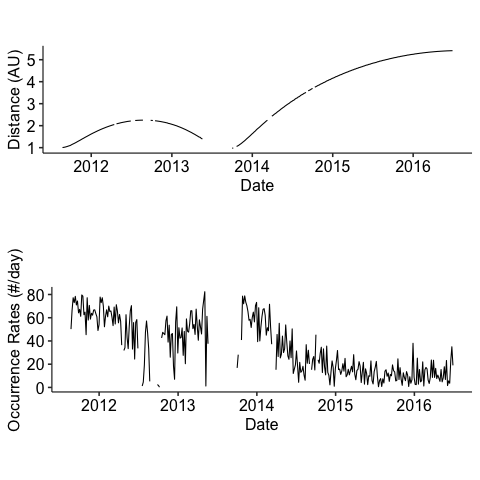

In [42]:
%%R
p1 <- ggplot(df, aes(x = time, y = radial_distance)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = time, y = o_rates)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

# save_plot("distance_and_or")
p

In [43]:
from beforerr.basics import pmap

In [44]:
s_resolution = timedelta(minutes=1)
avg_window = timedelta(days=30)

In [45]:
all_candidates_or_N1: pl.DataFrame = pl.concat(
    sat_candidates
    | pmap(
        lambda x: x.calc_or_normalized(s_resolution, avg_window).with_columns(
            sat=pl.lit(x.sat_id)
        )
    ),
    how="diagonal",
)

In [46]:
all_candidates_or_N2 = n2_normalize(all_candidates_or_N1)

## Occurrence rates versus time for all missions

In [47]:
def plot_or_time(df: pl.DataFrame):
    """Plot the occurence rate of the candidates with time.    
    """
    # Create a unique list of all satellites and sort them to let JNO' be plotted first
    all_sats = df["sat"].unique().to_list()
    all_sats.sort(key=lambda x: x != "JNO")

    # Plot each satellite separately
    for sat in all_sats:
        sat_df = df.filter(sat=sat)
        if sat == "JNO":
            sns.lineplot(sat_df, x="time", y="o_rates_normalized", label=sat)
        else:
            # Making the other satellites more distinct with linestyle and alpha
            sns.lineplot(
                sat_df,
                x="time",
                y="o_rates_normalized",
                linestyle="--",  # dashed line style
                alpha=0.5,  # keep the order of the legend
                label=sat,
            )

    ax = plt.gca()  # Get current axis
    # Set the y-axis and x-axis labels
    ax.set_ylabel("Occurrence Rates (#/day)")
    ax.set_xlabel("Date")
    ax.legend(title="Satellites")

    # savefig("occurrence_rates")
    return ax.figure

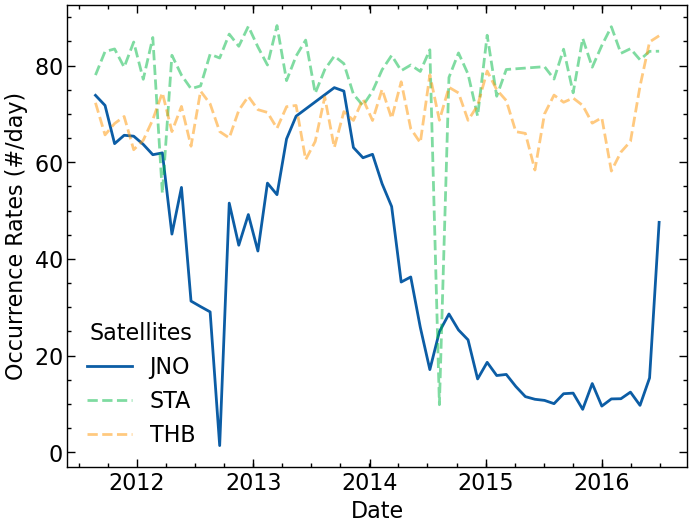

In [48]:
fig = plot_or_time(
    all_candidates_or_N1
)

Notes: `seaborn.lineplot` drops nans from the DataFrame before plotting, this is not desired...

In [49]:
%%R
plot_or_time <- function(df) {
  p <- ggline(
    df, x = "time", y = "o_rates_normalized", 
    color = "sat", linetype = "sat") 
  
  p <- p +   
    labs(x = "Date", y = "Occurrence Rates (#/day)", color="Satellites", linetype="Satellites") + 
    theme_pubr(base_size = 16) + 
    theme(legend.text = element_text(size=16)) +
    scale_color_okabeito(palette = "black_first")
    

  
  print(p)
  return(p)
}


In addition: Warning message:
Removed 6 rows containing missing values (`geom_point()`). 


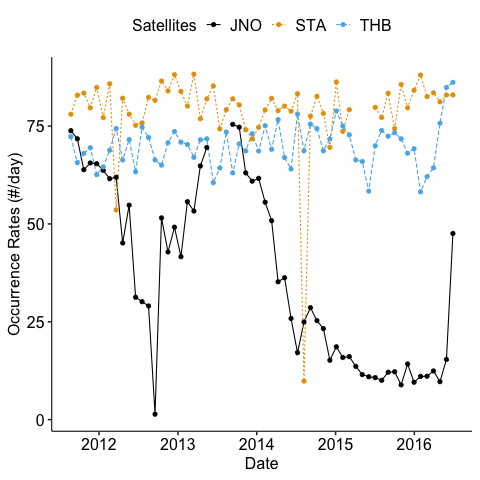

In [50]:
%R -i all_candidates_or_N1 -c conv_pl
%R plot_or_time(all_candidates_or_N1)

We noticed some anomalies in the occurrence rates of the magnetic discontinuities for Stereo-A data. Also for Juno, its occurrence rate is much higher when approaching Jupiter.

In [51]:
all_candidates_or_N1.filter(
    pl.col('time').is_in(pd.date_range('2014-01-01', '2015-01-01')),
    sat='STA'
)[["time", "o_rates", "o_rates_normalized", 'n1_factor']]

time,o_rates,o_rates_normalized,n1_factor
datetime[ns],f64,f64,f64
2014-01-10 00:00:00,71.5,74.697105,0.957199
2014-02-09 00:00:00,79.1,79.134805,0.99956
2014-03-11 00:00:00,79.366667,82.101482,0.96669
2014-04-10 00:00:00,78.933333,78.944298,0.999861
2014-05-10 00:00:00,80.1,80.116691,0.999792
2014-06-09 00:00:00,72.4,78.784856,0.918958
2014-07-09 00:00:00,74.0,83.265179,0.888727
2014-08-08 00:00:00,4.4,9.83342,0.447454
2014-09-07 00:00:00,12.266667,77.541703,0.158194


Surprisingly, we found out that the anomaly of STEREO-A data is not mainly due to data gap. We can inspect this data further. See [appendix](#stereo-a-anomaly-during-2014-08-period).

We remove the anomaly of STEREO-A and the restrict the time range to exclude Jupiter's effect.

In [52]:
all_candidates_or_N1_cleaned = (
    all_candidates_or_N1.sort("time")
    .filter(pl.col("time") < pd.Timestamp("2016-06-01"), pl.col("o_rates") > 10)
    .upsample("time", every=avg_window, by="sat", maintain_order=True)
    .with_columns(pl.col("sat").forward_fill())
)

all_candidates_or_N2_cleaned = n2_normalize(all_candidates_or_N1_cleaned)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 20 rows containing missing values (`geom_point()`). 
2: Removed 20 rows containing missing values (`geom_point()`). 
3: Removed 20 rows containing missing values (`geom_point()`). 


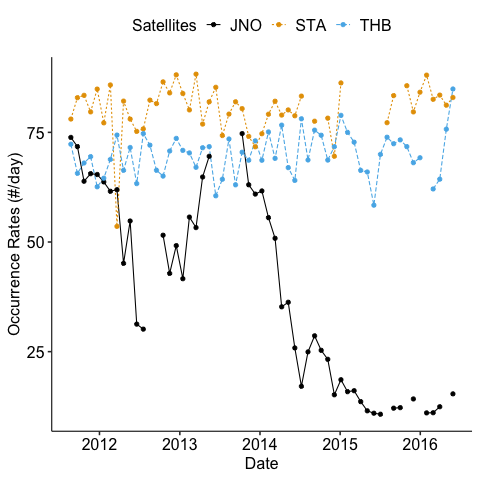

In [53]:
%%R -i all_candidates_or_N1_cleaned -c conv_pl
plot_or_time(all_candidates_or_N1_cleaned)
save_plot("ocr_time_cleaned")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 20 rows containing missing values (`geom_point()`). 
2: Removed 20 rows containing missing values (`geom_point()`). 
3: Removed 20 rows containing missing values (`geom_point()`). 


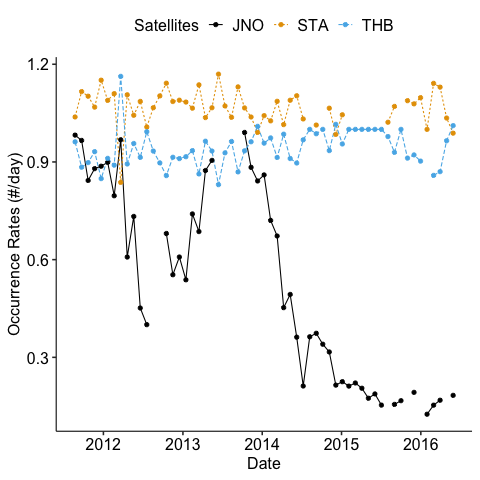

In [54]:
%%R -i all_candidates_or_N2_cleaned -c conv_pl
p <- plot_or_time(all_candidates_or_N2_cleaned)
p <- p + labs(y = "Normalized Occurrence Rates")
save_plot("ocr_time_N2_cleaned")


#### Plot the occurrence rates with radial distance


In [55]:
def link_coord2dim(df: pl.DataFrame, dim="time", coord: str = "radial_distance"):
    """Link the coord to a dimension across different subgroups

    Note: this idea is borrowed from the `xarray.DataArray.coords`.
    """
    base_df = df.filter(sat="JNO").select(dim, coord).rename({coord: f"ref_{coord}"})
    return df.join(base_df, on=dim)


def plot_or_r(df: pl.DataFrame):
    "plot normalized occurence rate over radial distance"

    sns.lineplot(x="ref_radial_distance", y="o_rates_normalized", hue="sat", data=df)

    ax = plt.gca()  # Get current axis
    ax.set_yscale("log")
    ax.set_xlabel("Referred Radial Distance (AU)")
    ax.set_ylabel("Normalized Occurrence Rate")
    # savefig('occurrence_rate_ratio')

    return ax.figure

In [56]:
%%R
plot_or_r <- function(df, target_sat = "JNO") {
  "plot normalized occurrence rate over radial distance"
  
  # Filter data for target_sat
  df_target <- df[df$sat == target_sat,]
  
  # Compute the linear model
  fit <- lm(o_rates_normalized ~ I(1/ref_radial_distance), data = df_target)
  
  # Extract coefficients
  intercept <- coef(fit)[1]
  slope <- coef(fit)[2]
  
  # Format equation
  equation <- sprintf("y ~ %.2f / x", slope)
  
  p <- ggscatter(df, x = "ref_radial_distance", y = "o_rates_normalized", color = "sat") +
    geom_smooth(data = df_target, formula = y ~ I(1/x), method = "lm", color="gray", linetype="dashed")
    
  p <- p +
    labs(x = "Referred Radial Distance (AU)", y = "Occurrence Rate  (#/day)", color="Satellites") +
    annotate("text", label = equation, x = Inf, y = Inf, hjust = 1.1, vjust = 1.5, size = 7) +
    theme_pubr(base_size = 16) + 
    theme(legend.text = element_text(size=16)) +
    scale_color_okabeito(palette = "black_first")
  
  return(p)
}

In [57]:
df = link_coord2dim(all_candidates_or_N1_cleaned).sort("ref_radial_distance")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 10 rows containing non-finite values (`stat_smooth()`). 
2: Removed 40 rows containing missing values (`geom_point()`). 
3: Removed 10 rows containing non-finite values (`stat_smooth()`). 
4: Removed 40 rows containing missing values (`geom_point()`). 
5: Removed 10 rows containing non-finite values (`stat_smooth()`). 
6: Removed 40 rows containing missing values (`geom_point()`). 


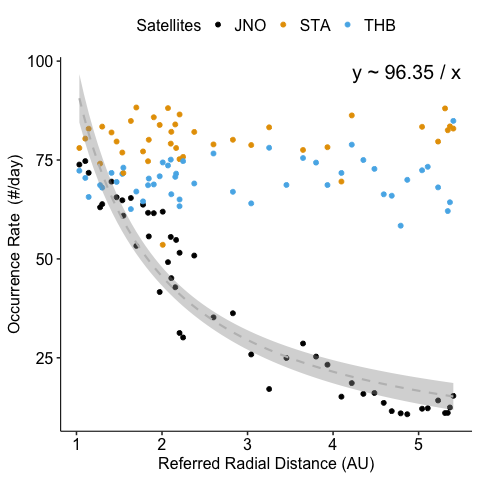

In [58]:
%%R -i df -c conv_pl
p <- plot_or_r(df)
print(p)
save_plot("ocr_r_cleaned")

In [59]:
df = link_coord2dim(all_candidates_or_N2_cleaned).sort("ref_radial_distance")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 10 rows containing non-finite values (`stat_smooth()`). 
2: Removed 40 rows containing missing values (`geom_point()`). 
3: Removed 10 rows containing non-finite values (`stat_smooth()`). 
4: Removed 40 rows containing missing values (`geom_point()`). 
5: Removed 10 rows containing non-finite values (`stat_smooth()`). 
6: Removed 40 rows containing missing values (`geom_point()`). 


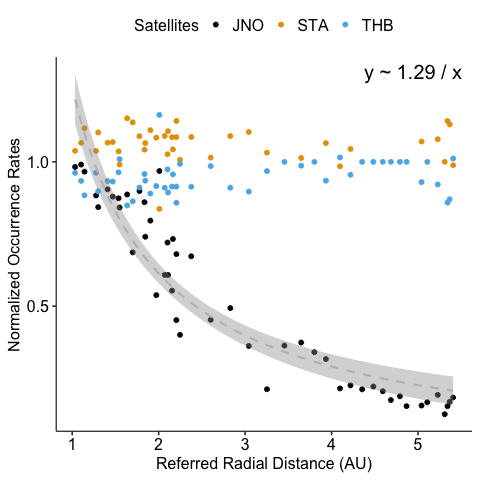

In [60]:
%%R -i df -c conv_pl
#| code-summary: R Code
p <- plot_or_r(df) + labs(y = "Normalized Occurrence Rates")
print(p)
save_plot("ocr_r_N2_cleaned")

## Appendix

### STEREO-A anomaly during 2014-08 period

In [ ]:
mag: pl.DataFrame = catalog.load('sta.inter_mag_1s').filter(pl.col('B')>0).collect()

In [ ]:
import plotly.graph_objects as go;
from plotly_resampler import FigureResampler
import plotly.express as px

In [ ]:
# px.line(mag, x='time', y='B') # This is extremely slow for large datasets

fig = FigureResampler(go.Figure())
fig.add_trace({"x": mag["time"], "y": mag['B']})
fig